# producing $p(z | photometry)$ for ELAsTiCC

_Alex Malz (GCCL@RUB)_

The goal here is to generate mock photo-$z$ posteriors for host galaxies. 
Ideally, we want them to contain no assumptions not present in the $p(z, photometry$ space from which they were drawn.
That's not really feasible. . .

TODO: explain why we can't do this

The next best thing to do is to aim for realistic complexity and make assumptions as similar to those of the underlying $p(z, photometry)$ model, by using [`pzflow`](https://github.com/jfcrenshaw/pzflow).

In [39]:
import corner
import numpy as np
import os
import pandas as pd

In [40]:
import pzflow
from pzflow import Flow
from pzflow.bijectors import Chain, ColorTransform, InvSoftplus, StandardScaler, RollingSplineCoupling, ShiftBounds
from pzflow.distributions import Uniform, Joint, Normal

In [58]:
pzflow.__version__

'2.0.6'

In [41]:
import qp
# help(qp)

In [42]:
import rail
# from rail.creation import Creator, engines
from rail.creation.degradation import LSSTErrorModel
from rail.evaluation import Evaluator

# awkwardly the rail dev branch is broken such that creators don't exist but degraders still do

In [43]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'DejaVu Serif'
# mpl.rcParams['axes.titlesize'] = 16
# mpl.rcParams['axes.labelsize'] = 14
# mpl.rcParams['savefig.dpi'] = 250
# mpl.rcParams['savefig.format'] = 'pdf'
# mpl.rcParams['savefig.bbox'] = 'tight'
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

In [44]:
# import GCRCatalogs


# cosmo=GCRCatalogs.load_catalog("cosmoDC2_v1.1.4_small")
# get_cols = ['redshift', 'mag_true_u_lsst', 'mag_true_g_lsst', 'mag_true_r_lsst', 'mag_true_i_lsst', 'mag_true_z_lsst', 'mag_true_y_lsst']
# # , 'stellar_mass', 'totalStarFormationRate']
# ### TODO: extract error columns as well

# print("Reading CosmoDC2 small catalog")
# data = cosmo.get_quantities(['redshift'])
# print("Catalog read.")
# df = pd.DataFrame(data)

## the hostlibs

Let's pick one hostlib for now.

TODO: loop through hostlibs later

In [45]:
mini = True

In [46]:
hl_heads = {'SNIa': 10,
            'SNII': 20, 
            'SNIbc': 10, 
            'UNMATCHED_KN_SHIFT': 10,
            'UNMATCHED_COSMODC2': 9}

prepends = list(hl_heads.keys())

In [47]:
for which_hl in hl_heads.keys():
    print((which_hl, os.path.getsize('/global/cfs/cdirs/lsst/groups/TD/SN/SNANA/SURVEYS/LSST/ROOT/PLASTICC_DEV/HOSTLIB/'+which_hl+'_GHOST.HOSTLIB.gz')/(1024**3)))

('SNIa', 0.2960810987278819)
('SNII', 0.35912969056516886)
('SNIbc', 0.4669061889871955)
('UNMATCHED_KN_SHIFT', 0.273594013415277)
('UNMATCHED_COSMODC2', 0.2735954010859132)


In [48]:
which_hl = prepends[1]#'SNIa_GHOST'# SNII_GHOST, SNIbc_GHOST, UNMATCHED_KN_SHIFT_GHOST_ABS, SNIa, UNMATCHED_COSMODC2_GHOST
hl_path = '/global/cfs/cdirs/lsst/groups/TD/SN/SNANA/SURVEYS/LSST/ROOT/PLASTICC_DEV/HOSTLIB/'+which_hl+'_GHOST.HOSTLIB.gz'
# skip 26lines
df = pd.read_csv(hl_path, skiprows=hl_heads[which_hl], delimiter=' ', header=0)
print(len(df))
# 3 hours gets through 599*1000 

2449001


In [50]:
df.columns

Index(['VARNAMES:', 'GALID', 'RA_GAL', 'DEC_GAL', 'ZTRUE', 'ZPHOT',
       'ZPHOT_ERR', 'u_obs', 'u_obs_err', 'g_obs', 'g_obs_err', 'r_obs',
       'r_obs_err', 'i_obs', 'i_obs_err', 'z_obs', 'z_obs_err', 'Y_obs',
       'Y_obs_err', 'SQRADIUS', 'a0_Sersic', 'b0_Sersic', 'n0_Sersic',
       'w0_Sersic', 'a1_Sersic', 'b1_Sersic', 'n1_Sersic', 'w1_Sersic',
       'a_rot', 'ELLIPTICITY', 'LOGMASS', 'LOG_SFR', 'OBJID2', 'ZPHOT_Q000',
       'ZPHOT_Q010', 'ZPHOT_Q020', 'ZPHOT_Q030', 'ZPHOT_Q040', 'ZPHOT_Q050',
       'ZPHOT_Q060', 'ZPHOT_Q070', 'ZPHOT_Q080', 'ZPHOT_Q090', 'ZPHOT_Q100',
       'IQR_ZPHOT', 'P_ZPHOT', 'logP50', 'Unnamed: 47', 'NBR_LIST'],
      dtype='object')

`pzflow` needs a grid upon which to evaluate redshift posteriors. 
We use a fine grid now but will compress it for the alert stream later.
And we can check what the redshift distribution of the hostlib is.

~~TODO: investigate the prevalence at $z \sim 3$ and maybe ask to re-run?~~

TODO: Try with grid of 100 redshifts overall!!!

In [51]:
zgrid = np.logspace(-3., np.log10(3.), 300)

Text(0.5, 1.0, 'hostlib redshift distribution')

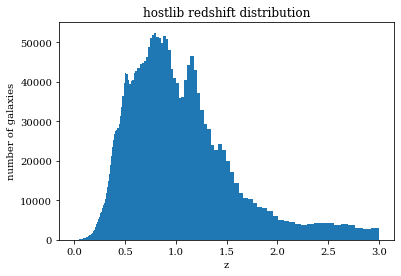

In [52]:
plt.hist(df['ZTRUE'], bins=zgrid);
plt.xlabel('z')
plt.ylabel('number of galaxies')
plt.title('hostlib redshift distribution')

rename the columns and make colors to match definitions of columns for normalizing flow

In [53]:
# # hl_df = df.rename(columns={'Y_obs':'y', 
# #                    'r_obs':'r', 
# #                    'u_obs':'u', 
# #                    'g_obs':'g', 
# #                    'z_obs':'z', 
# #                    'i_obs':'i', 
# #                    'ZTRUE':'redshift'})[['redshift', 'u', 'g', 'r', 'i', 'z', 'y']]
# hl_df = df.rename(columns={'ZTRUE':'redshift',
#                            'Y_obs':'y', 
#                            'r_obs':'r', 
#                            'u_obs':'u', 
#                            'g_obs':'g', 
#                            'z_obs':'z', 
#                            'i_obs':'i',})[['redshift', 
#                                                   'u', 'g', 'r', 'i', 'z', 'y']]
#                            # 'Y_obs_err':'y_err', 
#                            # 'r_obs_err':'r_err', 
#                            # 'u_obs_err':'u_err', 
#                            # 'g_obs_err':'g_err', 
#                            # 'z_obs_err':'z_err', 
#                            # 'i_obs_err':'i_err'})[['redshift', 
#                            #                        'u', 'g', 'r', 'i', 'z', 'y', 
#                            #                        'u_err', 'g_err', 'r_err', 'i_err', 'z_err', 'y_err']]
hl_df = df.rename(columns={'ZTRUE':'redshift',
                           'Y_obs':'y', 
                           'r_obs':'r', 
                           'u_obs':'u', 
                           'g_obs':'g', 
                           'z_obs':'z', 
                           'i_obs':'i',#})[['redshift','u', 'g', 'r', 'i', 'z', 'y']]
                            'Y_obs_err':'y_err', 
                           'r_obs_err':'r_err', 
                           'u_obs_err':'u_err', 
                           'g_obs_err':'g_err', 
                           'z_obs_err':'z_err', 
                           'i_obs_err':'i_err'})[['redshift', 
                                                  'u', 'g', 'r', 'i', 'z', 'y', 
                                                  'u_err', 'g_err', 'r_err', 'i_err', 'z_err', 'y_err']]

# hl_df_colors = hl_df.copy()
quantities = hl_df.columns#[:-6]
# print(quantities)

Index(['redshift', 'u', 'g', 'r', 'i', 'z', 'y', 'u_err', 'g_err', 'r_err',
       'i_err', 'z_err', 'y_err'],
      dtype='object')


In [56]:
# hl_df_colors = hl_df.copy()
# quantities = hl_df.columns
# for i in range(len(quantities)-2):
#     hl_df_colors[quantities[i+1]+'-'+quantities[i+2]] = hl_df[quantities[i+1]] -hl_df[quantities[i+2]]
# hl_df_colors = hl_df_colors.drop(columns = quantities)
# hl_df_colors['r'] = hl_df['r']# * std + mean
# hl_df_colors['redshift'] = hl_df['redshift']
# hl_df = hl_df_colors[['redshift', 'u-g', 'g-r', 'r-i', 'i-z', 'z-y', 'r']]

hl_df_colors = hl_df[['redshift', 'r', 'r_err']]
for i in range(len(quantities)-2-6):
    # print(quantities[i+1])
    hl_df_colors[quantities[i+1]+'-'+quantities[i+2]] = hl_df[quantities[i+1]] - hl_df[quantities[i+2]]
    # print(hl_df_colors.columns)
    hl_df_colors[quantities[i+1]+'-'+quantities[i+2]+'_err'] = np.sqrt(hl_df[quantities[6+i+1]]**2 + hl_df[quantities[6+i+2]]**2)
    # print(hl_df_colors.columns)
# hl_df_colors = hl_df_colors.drop(columns = quantities)
# print(hl_df_colors.columns)
# hl_df_colors['r'] = hl_df['r']# * std + mean
# hl_df_colors['r_err'] = hl_df['r_err']
# print(hl_df_colors.columns)
# hl_df_colors['redshift'] = hl_df['redshift']
# print(hl_df_colors.columns)
hl_df = hl_df_colors[['redshift', 'u-g', 'g-r', 'r-i', 'i-z', 'z-y', 'r', 'u-g_err', 'g-r_err', 'r-i_err', 'i-z_err', 'z-y_err', 'r_err']]

u
Index(['redshift', 'r', 'r_err', 'u-g'], dtype='object')


/tmp/ipykernel_41670/649352352.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hl_df_colors[quantities[i+1]+'-'+quantities[i+2]] = hl_df[quantities[i+1]] - hl_df[quantities[i+2]]
/tmp/ipykernel_41670/649352352.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hl_df_colors[quantities[i+1]+'-'+quantities[i+2]+'_err'] = np.sqrt(hl_df[quantities[6+i+1]]**2 + hl_df[quantities[6+i+2]]**2)
/tmp/ipykernel_41670/649352352.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

Index(['redshift', 'r', 'r_err', 'u-g', 'u-g_err'], dtype='object')
g
Index(['redshift', 'r', 'r_err', 'u-g', 'u-g_err', 'g-r'], dtype='object')
Index(['redshift', 'r', 'r_err', 'u-g', 'u-g_err', 'g-r', 'g-r_err'], dtype='object')
r
Index(['redshift', 'r', 'r_err', 'u-g', 'u-g_err', 'g-r', 'g-r_err', 'r-i'], dtype='object')


/tmp/ipykernel_41670/649352352.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hl_df_colors[quantities[i+1]+'-'+quantities[i+2]] = hl_df[quantities[i+1]] - hl_df[quantities[i+2]]
/tmp/ipykernel_41670/649352352.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hl_df_colors[quantities[i+1]+'-'+quantities[i+2]+'_err'] = np.sqrt(hl_df[quantities[6+i+1]]**2 + hl_df[quantities[6+i+2]]**2)
/tmp/ipykernel_41670/649352352.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

Index(['redshift', 'r', 'r_err', 'u-g', 'u-g_err', 'g-r', 'g-r_err', 'r-i',
       'r-i_err'],
      dtype='object')
i
Index(['redshift', 'r', 'r_err', 'u-g', 'u-g_err', 'g-r', 'g-r_err', 'r-i',
       'r-i_err', 'i-z'],
      dtype='object')
Index(['redshift', 'r', 'r_err', 'u-g', 'u-g_err', 'g-r', 'g-r_err', 'r-i',
       'r-i_err', 'i-z', 'i-z_err'],
      dtype='object')
z
Index(['redshift', 'r', 'r_err', 'u-g', 'u-g_err', 'g-r', 'g-r_err', 'r-i',
       'r-i_err', 'i-z', 'i-z_err', 'z-y'],
      dtype='object')


/tmp/ipykernel_41670/649352352.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hl_df_colors[quantities[i+1]+'-'+quantities[i+2]] = hl_df[quantities[i+1]] - hl_df[quantities[i+2]]


Index(['redshift', 'r', 'r_err', 'u-g', 'u-g_err', 'g-r', 'g-r_err', 'r-i',
       'r-i_err', 'i-z', 'i-z_err', 'z-y', 'z-y_err'],
      dtype='object')
Index(['redshift', 'r', 'r_err', 'u-g', 'u-g_err', 'g-r', 'g-r_err', 'r-i',
       'r-i_err', 'i-z', 'i-z_err', 'z-y', 'z-y_err'],
      dtype='object')


In [61]:
hl_df[:10000].to_pickle('../data_files/tiny_hl.pkl')

In [21]:
# hl_named = hl_df.rename(columns={'mag_true_y_lsst':'y', 
#                    'mag_true_r_lsst':'r', 
#                    'mag_true_u_lsst':'u', 
#                    'mag_true_g_lsst':'g', 
#                    'mag_true_z_lsst':'z', 
#                    'mag_true_i_lsst':'i',
#                     'ZTRUE':'redshift'})

In [22]:
# hl_named.columns

Let's look at a subset for now

In [23]:
if mini:
    nvis = 1000
else:
    nvis = len(hl_df)

In [24]:
hl_subset = hl_df.sample(nvis, random_state=0)

## normalizing flow model of redshift uncertainty

~~John Franklin Crenshaw (UW) had a pre-trained normalizing flow trained on a representative set of $10^{6}$ LSST-DESC DC2 galaxies, so I'm using that for now.~~

I'm making new normalizing flows using colors rather than magnitudes and a latent distribution with the freedom to encapsulate uncertainty (as the photometric uncertainties aren't included and there may not be time to add them with RAIL) without inducing edge effects.

In [25]:
knots = 64 # 64, 32, 16, 8

In [26]:
# flow = Flow(file='../data_files/model_photo-zs_sharp10_splbin2_epoch30_flow.pkl')#'desc-dc2-K=16.pkl')#Flow(file='../data_files/pzflow_dc2small_nofilter_div1000.pkl')
# sharpnesses =[3,10,30]
# spl_binses = [4,8,16]
# n_eps = [100]

flow = Flow(file='../data_files/model_photo-zs_uniform_splbin'+str(knots)+'_epoch100_flow.pkl')
# flow.latent = Uniform((0., 3.), (-1., 5.), (-1., 5.), (-1., 5.), (-1., 5.), (-1., 5.), (15, 35))
flow.latent = Uniform((-5, 5), (-5, 5), (-5, 5), (-5, 5), (-5, 5), (-5, 5), (-5, 5))

In [27]:
samples = flow.sample(1000, seed=0)

In [28]:
min(samples['redshift'])

0.12351381778717041

In [29]:
# flow.conditional_columns
# flow.data_columns
# help(flow)

Let's compare the distribution of data between the model and the hostlib.
Note how different they are! This is a very non-representative sample, so we expect pretty awful photo-$z$s.

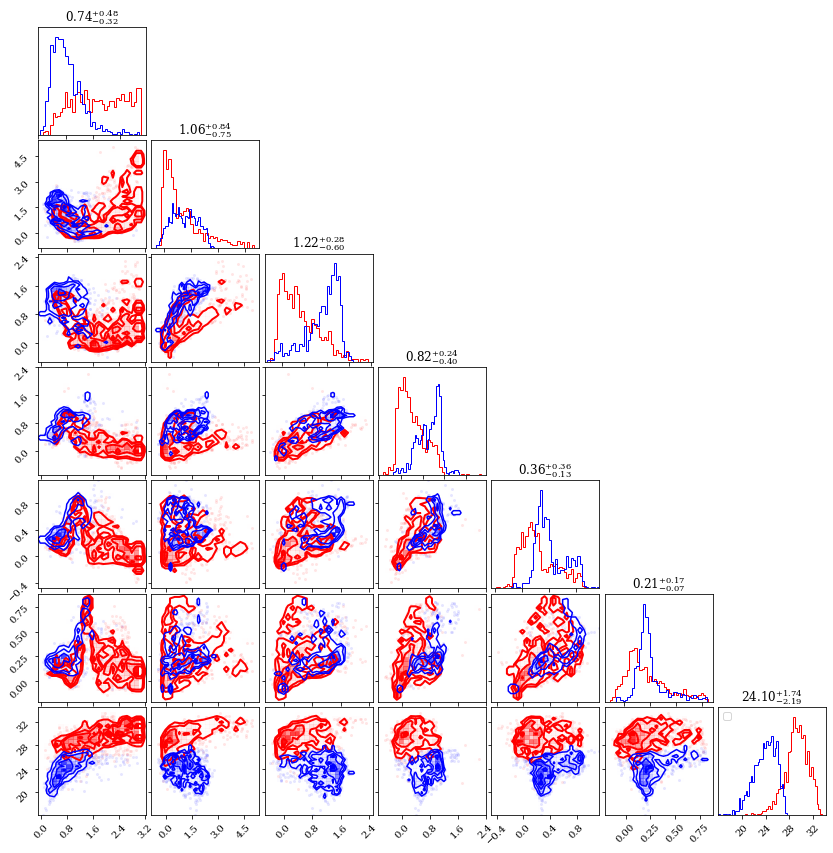

In [30]:
samples = flow.sample(nvis, seed=0)

fig = plt.figure(figsize=(12,12))

# ranges = [(-0.1,2.4), (19.5,33), (19,32), (19,29), (19,29), (19,28), (19,28)]

corner.corner(samples, fig=fig, color='r', bins=20, hist_bin_factor=2, data_kwargs={'ms':3}, contour_kwargs={'linewidths':2}, label='pz model')

corner.corner(hl_subset, fig=fig, bins=20, hist_bin_factor=2, color='b', data_kwargs={'ms':3}, show_titles=True, label='hostlib');

plt.legend()
plt.savefig('../plots/model_vs_hostlib'+str(knots)+'.png')

In [31]:
# for quality in ['redshift', 'u', 'g', 'r', 'i', 'z', 'y']:
#     plt.hist(samples[quality], bins=100, alpha=0.5, density=True, label='pz model samples');
#     plt.hist(hl_df[quality], bins=100, alpha=0.5, density=True, label='hostlib samples')
#     plt.title(quality)
#     plt.legend()
#     plt.show()

In [32]:
# plt.title('true redshift distributions')
# plt.hist(flow.sample(len(hl_df), seed=0)['redshift'], bins=zgrid, alpha=0.5, label='photo-z model', density=True);
# plt.hist(hl_df['redshift'], bins=zgrid, alpha=0.5, label='hostlib', density=True);
# plt.legend()
# plt.xlabel('z')
# plt.savefig('../plots/true_z_dists.png')

In [33]:
# flow.info

In [34]:
# flow.latent

## "estimated" posterior PDFs and diagnostics thereof

Now we can evaluate some posteriors and check that they look as expected.
They're way too narrow because there's no error model (and maybe the normalizing flow had too many knots).

In [35]:
flow_z = flow.posterior(hl_subset[['u-g', 'g-r', 'r-i', 'i-z', 'z-y', 'r']], column='redshift', grid=zgrid)#, err_samples=err_samples)
# err_samples is int for number of samples to draw from error distribution

# flow_z = flow.posterior(hl_df[['mag_true_u_lsst-mag_true_g_lsst',
#  'mag_true_g_lsst-mag_true_r_lsst',
#  'mag_true_r_lsst-mag_true_i_lsst',
#  'mag_true_i_lsst-mag_true_z_lsst',
#  'mag_true_z_lsst-mag_true_y_lsst',
#  'mag_true_r_lsst']][:nvis], column='redshift', grid=zgrid)

TODO: use RAIL to convolve with error model before evaluating, or make a new flow with ~~fewer~~ more knots

In [36]:
# flowEngine_truth = engines.FlowEngine.make_stage(name='truth', flow=flow_file, n_samples=n_samples)
# errorModel = LSSTErrorModel.make_stage(name='error_model')
# errorModel

In [37]:
idx = np.arange(0, nvis, int(nvis / 10 - 1))

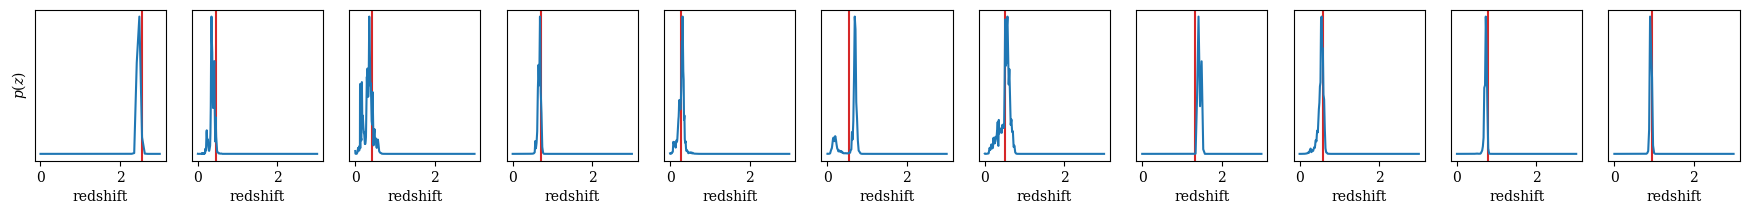

In [38]:
# flowz = flow.posterior(hl_subset[['u-g', 'g-r', 'r-i', 'i-z', 'z-y', 'r']], column='redshift', grid=zgrid)
pdfs = flow_z

fig, axes = plt.subplots(1,len(idx),figsize=(2*len(idx),2), dpi=100)
for i,ax in zip(idx, axes):
    true_z = hl_subset['redshift'].iloc[i]
    ax.axvline(true_z, 0, 1, c="C3",
               label='True z')
    ax.plot(zgrid, pdfs[i])
    ax.set(xlabel="redshift",
           # xticks=[0,0.5,1,1.5,2],
           yticks=[])
# axes[0].legend()
axes[0].set(ylabel='$p(z)$')
# plt.show()
plt.savefig('../plots/example_pdfs_native'+str(knots)+'.png')

TODO: convolve with errors by retraining if not with RAIL? See https://github.com/jfcrenshaw/pzflow/blob/main/examples/gaussian_errors.ipynb

quick and dirty diagnostics of modes of PDFs

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(hl_subset['redshift'], zgrid[np.argmax(flow_z, axis=1)], s=1, c='k')
plt.plot([0., 3], [0., 3], c='r')#[min(hl_scaled['ZTRUE'][:nvis]), max(hl_scaled['ZTRUE'][:nvis])], [min(hl_scaled['ZTRUE'][:nvis]), max(hl_scaled['ZTRUE'][:nvis])], c='r')
plt.xlabel(r'$z_{true}$')
plt.ylabel(r'$z_{mode}$')
# plt.xlim(0., 0.3)
# plt.ylim(0., 0.3)
plt.savefig('../plots/zmode_vs_ztrue'+str(knots)+'.png')

In [ ]:
plt.title('point estimate bias')
plt.xlabel(r'$z_{true}$')
plt.ylabel(r'$z_{mode} - z_{true}$')
plt.scatter(hl_subset['redshift'], zgrid[np.argmax(flow_z, axis=1)] - hl_subset['redshift'], s=1, c='k')
plt.savefig('../plots/point_estimate_bias'+str(knots)+'.png')

TODO: make PIT plot

## convert to qp and evaluate metrics

Anyway, let's cut to the important part, the compression of the posteriors using `qp`.

First, make a qp ensemble.

In [ ]:
in_pdfs = qp.Ensemble(qp.interp, data=dict(xvals=zgrid, yvals=flow_z, check_input=True))#, ancil=dict(GALID=df['GALID'][:nvis]))
# in_pdfs.set_ancil({'GALID': hl_subset['GALID']})

In [ ]:
in_pdfs.ancil

In [ ]:
iqr = in_pdfs.ppf(0.75) - in_pdfs.ppf(0.25)

In [ ]:
# idx = np.arange(0, nvis, int(nvis / 10 - 1))
fig, axes = plt.subplots(1,len(idx),figsize=(2*len(idx),2), dpi=100)
for i,ax in zip(idx, axes):
    true_z = hl_subset['redshift'].iloc[i]
    ax.axvline(true_z, 0, 1, c="C3",
               label='True z')
    ax.plot(zgrid, in_pdfs[i].pdf(zgrid)[0])
    ax.set(xlabel="redshift",
           # xticks=[0,0.5,1,1.5,2],
           yticks=[])
    # ax.set_xlim(0, 0.25)
# axes[0].legend()
axes[0].set(ylabel='$p(z)$')
# plt.show()
plt.savefig('../plots/example_pdfs_qp'+str(knots)+'.png')

Then choose quantile values.

In [ ]:
quants = np.linspace(0., 1., 11)#[1:-1]
# quants[-1] = 0.999
# print(quants)
q50_ind = np.argwhere(quants == 0.5)
# print(q50_ind)

convert ensemble to quantiles

In [ ]:
out_pdfs = in_pdfs.convert_to(qp.quant_piecewise_gen, quants=quants, check_input=False)

In [ ]:
zmeds = out_pdfs.objdata()['locs'][:,q50_ind].reshape(in_pdfs.npdf)

In [ ]:
zmeds.shape

also save p50

In [ ]:
import scipy.stats as sps

# # evaluate a single distribution's PDF at one value
# print("PDF at one point for one distribution:", 
#       sps.norm(loc=0, scale=1).pdf(0.5))

# # evaluate a single distribution's PDF at multiple value
# print("PDF at three points for one distribution:", 
#       sps.norm(loc=0, scale=1).pdf([0.5, 1., 1.5]))

# # evalute three distributions' PDFs at one shared value
# print("PDF at one point for three distributions:", 
#       sps.norm(loc=[0., 1., 2.], scale=1).pdf(0.5))

# evalute three distributions' PDFs each at one different value
print("PDF at one different point for three distributions:", 
      sps.norm(loc=[0., 0., 0.], scale=1).pdf([0.5, 1., 1.5]))

# evalute three distributions' PDFs each at four different values
# (note the change in shape of the argument)
print("PDF at four different points for three distributions:\n",
      sps.norm(loc=[0., 1., 2.], scale=1).pdf([[0.5],[1.],[1.5],[2]]))

# evalute three distributions' PDFs at each of four different values
# (note the change in shape of the argument)
print("PDF at four different points for three distributions: broadcast reversed\n",
      sps.norm(loc=[[0.], [1.], [2.]], scale=1).pdf([0.5,1.,1.5,2]))



In [ ]:
import multiprocessing
from multiprocessing import Pool

nps = 4

def f(i):
    return in_pdfs[i].pdf(zmeds[i])

with Pool(nps) as p:
    p50 = p.map(f, range(in_pdfs.npdf))

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(hl_subset['redshift'], zmeds, s=0.5, c=p50, alpha=1)
plt.plot([0., 3], [0., 3], c='r')#[min(hl_scaled['ZTRUE'][:nvis]), max(hl_scaled['ZTRUE'][:nvis])], [min(hl_scaled['ZTRUE'][:nvis]), max(hl_scaled['ZTRUE'][:nvis])], c='r')
plt.xlabel(r'$z_{true}$')
plt.ylabel(r'$z_{median}$')
# plt.xlim(0., 0.3)
# plt.ylim(0., 0.3)
plt.colorbar()
plt.savefig('../plots/zmed_vs_ztrue'+str(knots)+'.png')

In [ ]:
out_pdfs.set_ancil(dict(GALID=df['GALID'][:nvis].values, p50=p50, iqr=iqr))

In [ ]:
# out_pdfs.ancil

In [ ]:
# out_pdfs.objdata()['locs'].shape

In [ ]:
# out_pdfs.objdata()['locs'][:,1:-1]

TODO: change quantile output to have ind_logp_q as metadata since it can't be ancillary

TODO: don't save padded quants

TODO: why are locs not redshifts???

In [ ]:
# out_pdfs.set_ancil({'P_FOR_WHICH_Q': q50_ind})

## save for hostlib integration

TODO: qp should allow overwriting a file, but with warning

In [ ]:
out_pdfs.write_to('/global/cfs/cdirs/lsst/groups/TD/SN/SNANA/SURVEYS/LSST/ROOT/PLASTICC_DEV/HOSTLIB/zquants/quants'+which_hl+str(knots)+'.fits')

reconstruction of pdfs doesn't work in new qp implementation!!!

In [ ]:
out_pdfs_eval = out_pdfs.pdf(zgrid)
out_pdfs_eval

TODO: fix qp quantile reconstruction bug!

Issue is that input PDFs aren't normalized, even when converted to qp

In [ ]:
# with open('/global/u2/a/aimalz/ve3_elasticc/lib/python3.9/site-packages/pzflow/distributions.py', 'r') as f:
#     for l in f:
#         print(l)

In [ ]:
# idx = np.arange(0, nvis, int(nvis / 10 - 1))
fig, axes = plt.subplots(1,len(idx),figsize=(2*len(idx),2), dpi=100)
for i,ax in zip(idx, axes):
    true_z = hl_subset['redshift'].iloc[i]
    ax.axvline(true_z, 0, 1, c="C3",
               label='True z')
    ax.plot(zgrid, out_pdfs_eval[i])
    ax.set(xlabel="redshift",
           # xticks=[0,0.5,1,1.5,2],
           yticks=[])
# axes[0].legend()
    # ax.set_xlim(0, 0.25)
axes[0].set(ylabel='$p(z)$')
# plt.show()
plt.savefig('../plots/example_pdfs_recon'+str(knots)+'.png')

In [ ]:
# fig, axes = qp.plotting.plot_native(out_pdfs[1], xlim=(0, 3))

this would be a great place to evaluate some metrics with RAIL but the cecification has broken evaluation of standalone qp ensembles. . .

In [ ]:
# eval_dict = dict(interp=in_pdfs, quantiled=out_pdfs)
# truth = hl_subset['redshift']

# result_dict = {}
# for key, val in eval_dict.items():
#     the_eval = Evaluator.make_stage(name=f'{key}_eval', truth=truth)
#     result_dict[key] = the_eval.evaluate(val, truth)

In [ ]:
# out_ppfs = out_pdfs.ppf(quants)

# scratch below here, please ignore

In [ ]:
# # in_pdfs.write_to('/global/cfs/cdirs/desc-td/SN/SNANA/SURVEYS/LSST/ROOT/PLASTICC_DEV/HOSTLIB/TEMP_HOSTLIBS/zquant_test/mini_interp'+which_hl+'.fits')
# out_pdfs.write_to('/global/cfs/cdirs/lsst/groups/TD/SN/SNANA/SURVEYS/LSST/ROOT/PLASTICC_DEV/HOSTLIB/zquants/mini_quants'+which_hl+'.fits')

TODO: try reconstructing them to check the saved values aren't nonsense

In [ ]:
# def quant_to_grid(qp_quant, )

In [ ]:
# zs = uncompressed * df['ZTRUE'].std() + df['ZTRUE'].mean()
# for quality in ['logmass', 'logSFRtot', 'mag_true_u_lsst', 'mag_true_g_lsst', 'mag_true_r_lsst', 'mag_true_i_lsst', 'mag_true_z_lsst', 'mag_true_y_lsst']:
#     data_scaled[quality] = (data[quality]-data[quality].mean())/data[quality].std()

why are the true posteriors so crazy compared to the true redshifts? maybe because of rescaling over all dimensions for the flow?

In [ ]:
# cmap = plt.get_cmap('tab10')
# maxpdfs = 5
# for i in range(maxpdfs):
#     plt.plot(zgrid, flow_z[i], color=cmap(i/maxpdfs))
#     plt.vlines(hl_scaled['ZTRUE'][i], 0., max(flow_z[i]), color=cmap(i/maxpdfs))
# plt.xlabel(r'$z$')
# plt.ylabel(r'$p(z)$')
# plt.semilogx()
# plt.show()
# for i in range(maxpdfs):
#     plt.plot(zgrid, flow_z[i], color=cmap(i/maxpdfs))
#     plt.vlines(hl_scaled['ZTRUE'][i], 0., max(flow_z[i]), color=cmap(i/maxpdfs))
# plt.xlabel(r'$z$')
# plt.ylabel(r'$p(z)$')

In [ ]:
# # flow_samps = flow.sample(1, conditions=hl_scaled[['mag_true_y_lsst',
# #  'mag_true_r_lsst',
# #  'mag_true_u_lsst',
# #  'mag_true_g_lsst',
# #  'mag_true_z_lsst',
# #  'mag_true_i_lsst',
# #  'logSFRtot',
# #  'logmass']][:nvis], seed=0)
# flow_samps = flow.sample(1, conditions=hl_named[['u', 'g', 'r', 'i', 'z', 'y']][:nvis], seed=0)
# plt.hist(flow_samps['redshift'], bins=zgrid, alpha=0.5, density=True, label='pz model samples');
# plt.hist(hl_df['ZTRUE'][:nvis], bins=zgrid, alpha=0.5, density=True, label='hostlib samples');
# plt.legend()

Why do these distributions still not even come close to matching? The flow should have coverage over the hostlib range but doesn't. The redshifts might be normalized somehow, too?

renormalize

Note DC2 SFRs are Msol/Gyr but hostlibs are log10 Msol/yr

In [ ]:
# properties = {}
# properties['logmass'] = ( 6.6518884, 0.96087)
# properties['logSFRtot'] = ( 6.24535, 1.6989895)
# properties['mag_true_u_lsst'] = ( 30.86386, 3.0129747)
# properties['mag_true_g_lsst'] = ( 29.790226, 2.088292)
# properties['mag_true_r_lsst'] = ( 29.342756, 1.87558)
# properties['mag_true_i_lsst'] = ( 29.0863, 1.9085665)
# properties['mag_true_z_lsst'] = ( 28.870272, 1.9486268)
# properties['mag_true_y_lsst'] = ( 28.658136, 1.9420407)

In [ ]:
# def make_normed(data, properties):
#     data_out = data.copy()
#     for quality in properties.keys():
#         data_out[quality] = (data[quality] - properties[quality][0]) / properties[quality][1]
#     return data_out

# def do_un_norm(data, properties):
#     data_out = data.copy()
#     for quality in properties.keys():
#         data_out[quality] = data[quality] * properties[quality][1] + properties[quality][0]
#     return data_out

In [ ]:
# # data = hl_df.copy()
# # for quality in ['logmass', 'logSFRtot', 'mag_true_u_lsst', 'mag_true_g_lsst', 'mag_true_r_lsst', 'mag_true_i_lsst', 'mag_true_z_lsst', 'mag_true_y_lsst']:
# #     plt.hist(data[quality], bins=100)
# #     plt.title(quality+' pre-normalization')
# #     plt.show()
# hl_scaled = make_normed(hl_df, properties)
# # data.copy()
# # for quality in ['logmass', 'logSFRtot', 'mag_true_u_lsst', 'mag_true_g_lsst', 'mag_true_r_lsst', 'mag_true_i_lsst', 'mag_true_z_lsst', 'mag_true_y_lsst']:
# #     data_scaled[quality] = (data[quality]-properties[quality][0])/properties[quality][1]
# # for quality in ['redshift']:#['logmass', 'logSFRtot', 'mag_true_u_lsst', 'mag_true_g_lsst', 'mag_true_r_lsst', 'mag_true_i_lsst', 'mag_true_z_lsst', 'mag_true_y_lsst']:
# #     plt.hist(data_scaled[quality], bins=100)
# #     plt.title(quality+' post-normalization')
# #     plt.show()

make a NF from DC2? No, too slow!

In [ ]:
import GCRCatalogs
from GCRCatalogs import cosmodc2

cosmo = GCRCatalogs.load_catalog("cosmoDC2_v1.1.4_small")
quantities = ['redshift', 'mag_u', 'mag_g', 'mag_r', 'mag_i', 'mag_z', 'mag_y', 'magerr_u', 'magerr_g', 'magerr_r', 'magerr_i', 'magerr_z', 'magerr_y']#, 'stellar_mass', 'totalStarFormationRate']
# quantities = ['redshift', 'mag_u', 'mag_g', 'mag_r', 'mag_i', 'mag_z', 'mag_y']#, 'stellar_mass', 'totalStarFormationRate']
# quantities = ['redshift', 'mag_true_u_lsst', 'mag_true_g_lsst', 'mag_true_r_lsst', 'mag_true_i_lsst', 'mag_true_z_lsst', 'mag_true_y_lsst']#, 'stellar_mass', 'totalStarFormationRate']

In [ ]:
# cosmo = GCRCatalogs.load_catalog("cosmoDC2_v1.1.4_small")
# quantities = ['redshift', 'mag_true_u_lsst', 'mag_true_g_lsst', 'mag_true_r_lsst', 'mag_true_i_lsst', 'mag_true_z_lsst', 'mag_true_y_lsst']#, 'stellar_mass', 'totalStarFormationRate']

print("Reading CosmoDC2 small catalog")
data = cosmo.get_quantities(quantities)
print("Catalog read.")
data = pd.DataFrame(data)
# data['logSFRtot'] = onp.log10(data['totalStarFormationRate'])
# data['logmass']   = onp.log10(data['stellar_mass'])
# data.drop(columns=['totalStarFormationRate', 'stellar_mass'], inplace=True)

# plt.figure(figsize=(10,7))
# plt.plot(data['redshift'].sample(n=100000, random_state=1), (data['mag_true_g_lsst'] - data['mag_true_r_lsst']).sample(n=100000, random_state=1), 'o', ms=0.1)
# plt.xlabel("DC2 Redshift")
# plt.ylabel(r"$g-r$")
# # plt.savefig("../plots/ogdc2_zvcolor_gr.png")
# plt.clf()

In [ ]:
data.columns

In [ ]:
# data_scaled[['mag_true_y_lsst',
#  'mag_true_r_lsst',
#  'mag_true_u_lsst',
#  'mag_true_g_lsst',
#  'mag_true_z_lsst',
#  'mag_true_i_lsst',
#  'logSFRtot',
#  'logmass']]

In [ ]:
# test_samps = flow.sample(1, data_scaled[['mag_true_y_lsst',
#  'mag_true_r_lsst',
#  'mag_true_u_lsst',
#  'mag_true_g_lsst',
#  'mag_true_z_lsst',
#  'mag_true_i_lsst',
#  'logSFRtot',
#  'logmass']][:100])

In [ ]:
# test_samps

In [ ]:
# plt.hist(test_samps['redshift'] - flow_df['ZTRUE'][:100])

something has gone wrong here!